In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [63]:
data = data[['Date','Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Transformation**

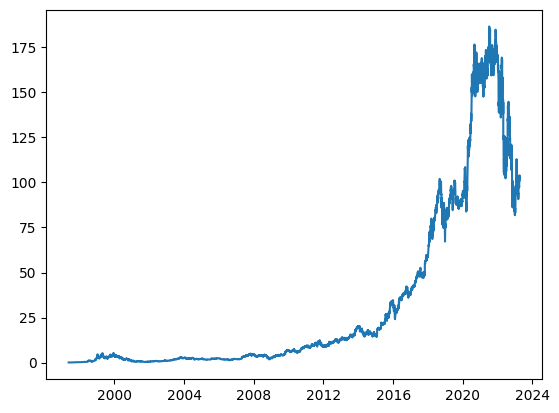

In [65]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [66]:
## We use LSTM to look at the history

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df['Date'] = pd.to_datetime(df['Date'])

  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)

  return df


lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [67]:
## Converting df to numpy array

shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [68]:
## Standardizing Data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np


array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

## Train & Test

In [69]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:,0]

X.shape, y.shape

((6509, 7), (6509,))

In [70]:
## fliping the columns as the learning happens like 7,6,5,4,3,2,1 days

X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [71]:
split_index = int(len(X) * 0.90)  ## Training data 80%
split_index

5858

In [72]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7), (651, 7), (5858,), (651,))

In [73]:
## Reshaping wehere matrices are going to get another dimension

X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7, 1), (651, 7, 1), (5858, 1), (651, 1))

In [74]:
## Wrap up arrays in torch tensors

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5858, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5858, 1]),
 torch.Size([651, 1]))

In [75]:
## Dataset object, custom class

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
      def __init__(self,X,y):
        self.X =X
        self.y = y

      def __len__(self):
        return len(self.X)

      def __getitem__(self,i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [76]:
## To  load the data

from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [77]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break


torch.Size([16, 7, 1]) torch.Size([16, 1])


In [78]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [79]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [80]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [81]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.549
Batch 200, Loss: 0.126
Batch 300, Loss: 0.067

Val Loss: 0.688
***************************************************

Epoch: 2
Batch 100, Loss: 0.035
Batch 200, Loss: 0.017
Batch 300, Loss: 0.008

Val Loss: 0.327
***************************************************

Epoch: 3
Batch 100, Loss: 0.003
Batch 200, Loss: 0.006
Batch 300, Loss: 0.004

Val Loss: 0.260
***************************************************

Epoch: 4
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003

Val Loss: 0.218
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.178
***************************************************

Epoch: 6
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.131
***************************************************

Epoch: 7
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.085
*****************

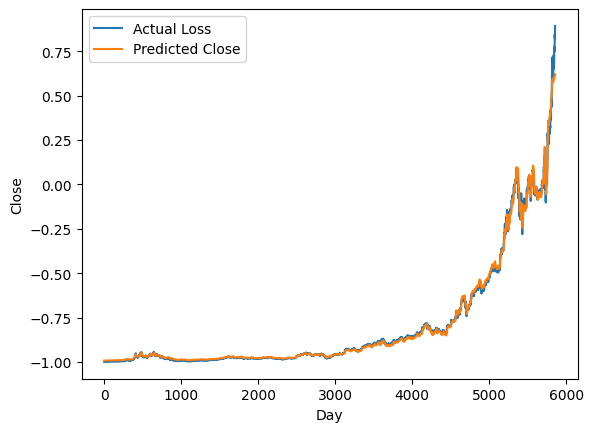

In [82]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

    plt.plot(y_train, label='Actual Loss')
    plt.plot(predicted, label='Predicted Close')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

In [83]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([  0.79127136,   0.79051545,   0.78989294, ..., 151.03885469,
       151.10085   , 151.24773451])

In [84]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.72548002e+02, 1.74955992e+02, 1.76572494e+02])

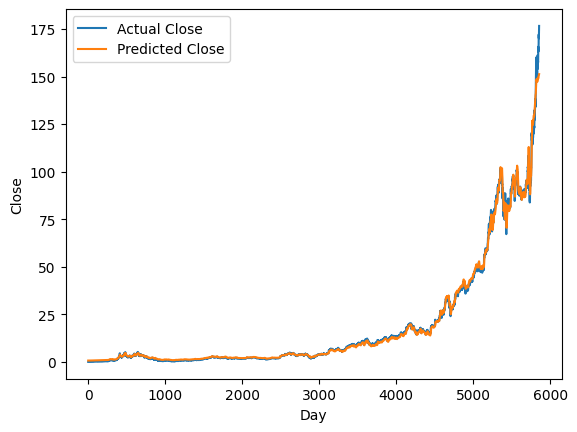

In [85]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [86]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([151.44894413, 152.05800881, 151.99685834, 151.96887319,
       151.20549834, 151.07835071, 150.54818914, 149.83779432,
       149.3122571 , 149.15051572, 148.90701991, 148.28539387,
       147.6866395 , 147.33736149, 147.51039142, 147.16769422,
       147.12129501, 147.43108256, 148.00662064, 148.37842017,
       148.47147427, 149.00128568, 149.06343661, 149.32991526,
       149.06348663, 149.21572918, 149.22314928, 149.29529371,
       149.97085578, 150.57227249, 150.95006367, 151.21268499,
       151.29038755, 151.004889  , 150.66650491, 150.23607274,
       149.88700594, 149.70346004, 149.55271263, 149.88550524,
       149.68014371, 149.84081238, 149.36033487, 148.81199824,
       148.40567165, 148.52272016, 149.01799895, 149.48556494,
       149.6029525 , 149.37231818, 149.46464417, 149.1592253 ,
       148.85074391, 148.5988998 , 148.63224298, 148.70287561,
       148.67143886, 148.61760844, 148.54130653, 148.51712313,
       148.70320909, 148.94078551, 149.01773216, 149.29

In [87]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([168.39999674, 164.73100188, 157.49200233, 163.43049557,
       158.75549155, 155.81100359, 155.14849755, 157.80650317,
       153.9050009 , 150.4364931 , 147.74550002, 148.02350066,
       156.44949298, 149.99299379, 150.98950412, 154.7564998 ,
       158.7025004 , 157.24400444, 157.43649336, 161.06300192,
       156.25000082, 159.96000907, 154.99800025, 159.78450022,
       159.52749817, 164.33250669, 172.14649963, 172.18150469,
       168.18550321, 166.93249662, 163.63549582, 160.36050519,
       160.85049265, 159.24699637, 158.82000468, 160.2200014 ,
       160.35200682, 164.31649929, 158.13900677, 160.55050963,
       151.80749309, 150.2240005 , 152.42050404, 162.05800044,
       166.1000065 , 165.56849431, 157.18699477, 151.75100589,
       156.86950922, 155.51400528, 156.44050549, 156.55299635,
       156.78300259, 155.27299395, 155.85099984, 154.96999843,
       154.91949732, 155.90300164, 159.25349382, 159.76699769,
       158.40199492, 161.00399689, 160.17649797, 159.33

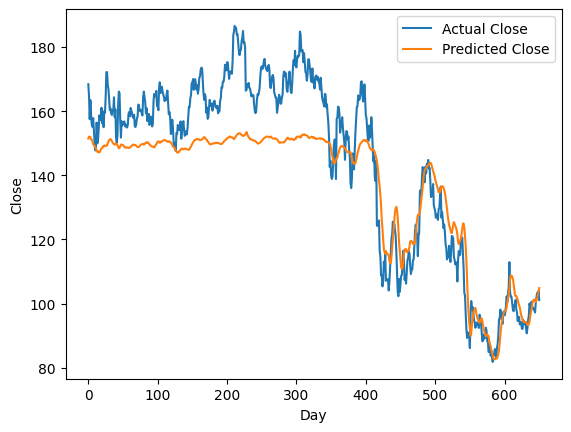

In [88]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()